In [17]:
import random
import numpy as np
from utils import *
from ploting import *

3861


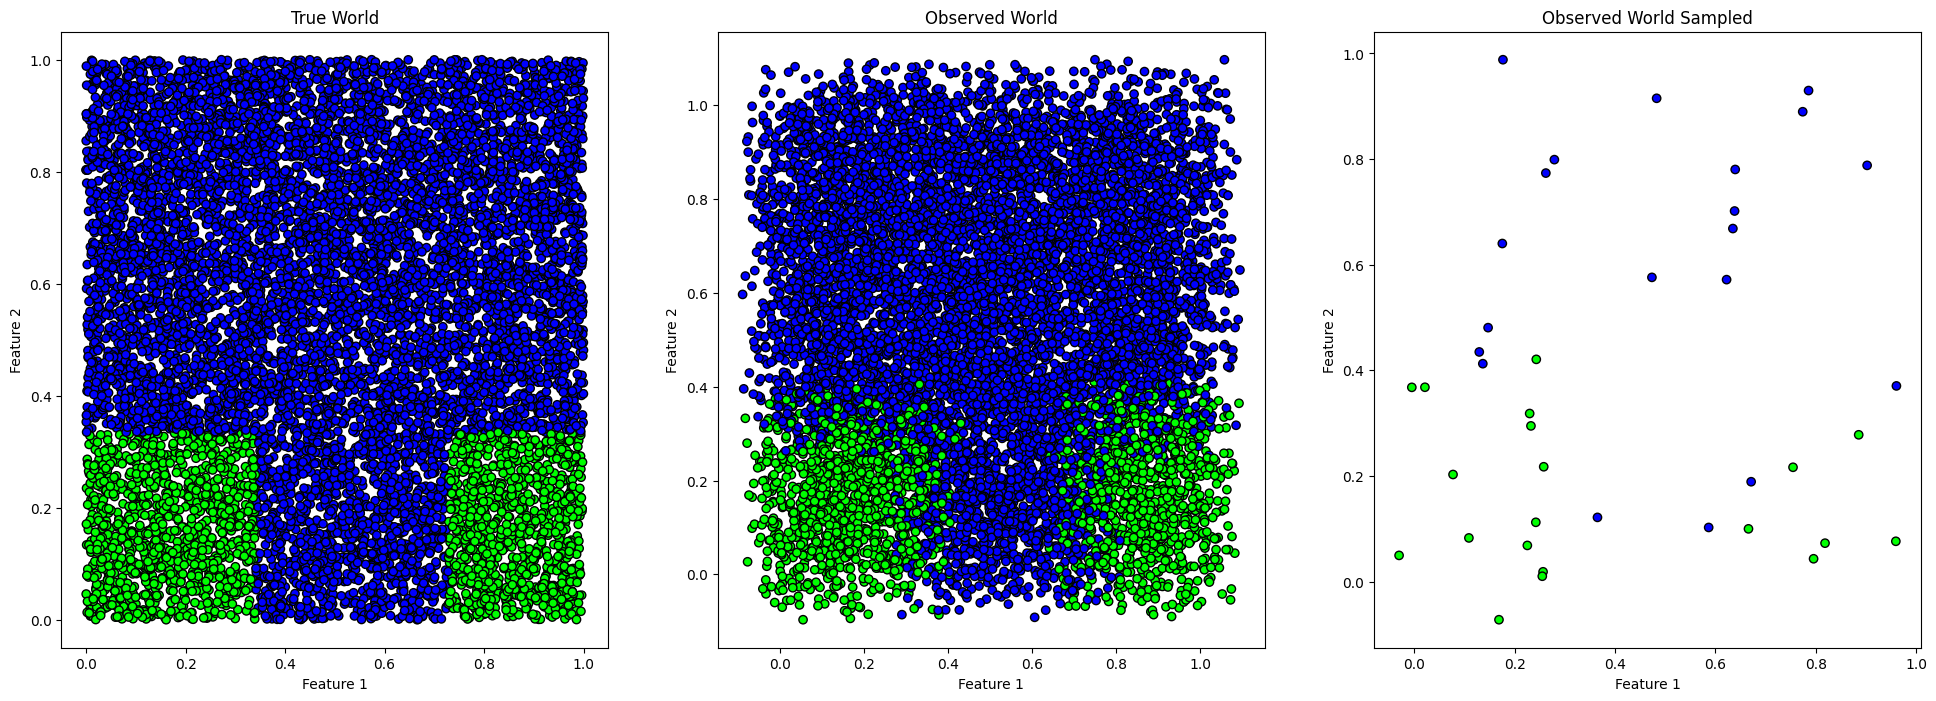

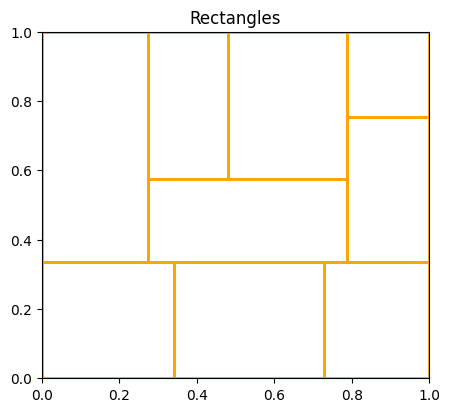

In [2]:
seed = random.randint(0, 10000)
print(seed)
random.seed(2427) # 2427
feature_bounds = [(0, 1), (0, 1)]
world_coords = generate_world_bounds(features = 2, feature_bounds = feature_bounds, endT = .2, endA = .1, max_depth = 4)
bounds_with_class = {}
# seed(None)
for i, bounds in enumerate(world_coords):
    bounds_with_class[bounds] = random.randint(0, 1)

data = generate_true_values(bounds_with_class, feature_bounds)

#Class, True Value 1, True Value 2, Observed Value 1, Uncertainty 1, Observed Value 2, Uncertainty 2
world = data_to_world(data, errRange = 0.1, corr = 1)

# draw_true_world(world, "brg")
# draw_observed_world(world, "brg")
# random.seed(None)
# draw_observed_world(sample_data(world), "brg")
np.random.seed(2427)
draw_combined_world(world, sample_data(world), "brg")
draw_world_grid(world_coords, feature_bounds)

In [3]:
import pandas as pd 
  
df = pd.DataFrame(world, columns=["True Value 1", "True Value 2", "Class", "Observed Value 1", "Uncertainty 1", "Observed Value 2", "Uncertainty 2"]) 

df
# df.to_csv(f"../data/2_feature/worlds/seed22/errR({0.2})_corr({.6}).csv")

,True Value 1,True Value 2,Class,Observed Value 1,Uncertainty 1,Observed Value 2,Uncertainty 2
0,1.0,0.057032,0.128001,0.069745,0.012713,0.099756,0.028246
1,0.0,0.825050,0.454439,0.879180,0.054131,0.546554,0.092114
2,0.0,0.038480,0.661231,0.010010,0.028470,0.715358,0.054127
3,0.0,0.953030,0.790760,0.892691,0.060339,0.887304,0.096544
4,1.0,0.056784,0.083428,0.076315,0.019531,0.108535,0.025106
...,...,...,...,...,...,...,...
9995,0.0,0.506322,0.475683,0.545278,0.038955,0.526692,0.051009
9996,1.0,0.918795,0.025469,0.893192,0.025603,-0.051875,0.077344
9997,1.0,0.814592,0.254392,0.840401,0.025808,0.353968,0.099576
9998,0.0,0.000547,0.988356,-0.022159,0.022705,1.064096,0.075739


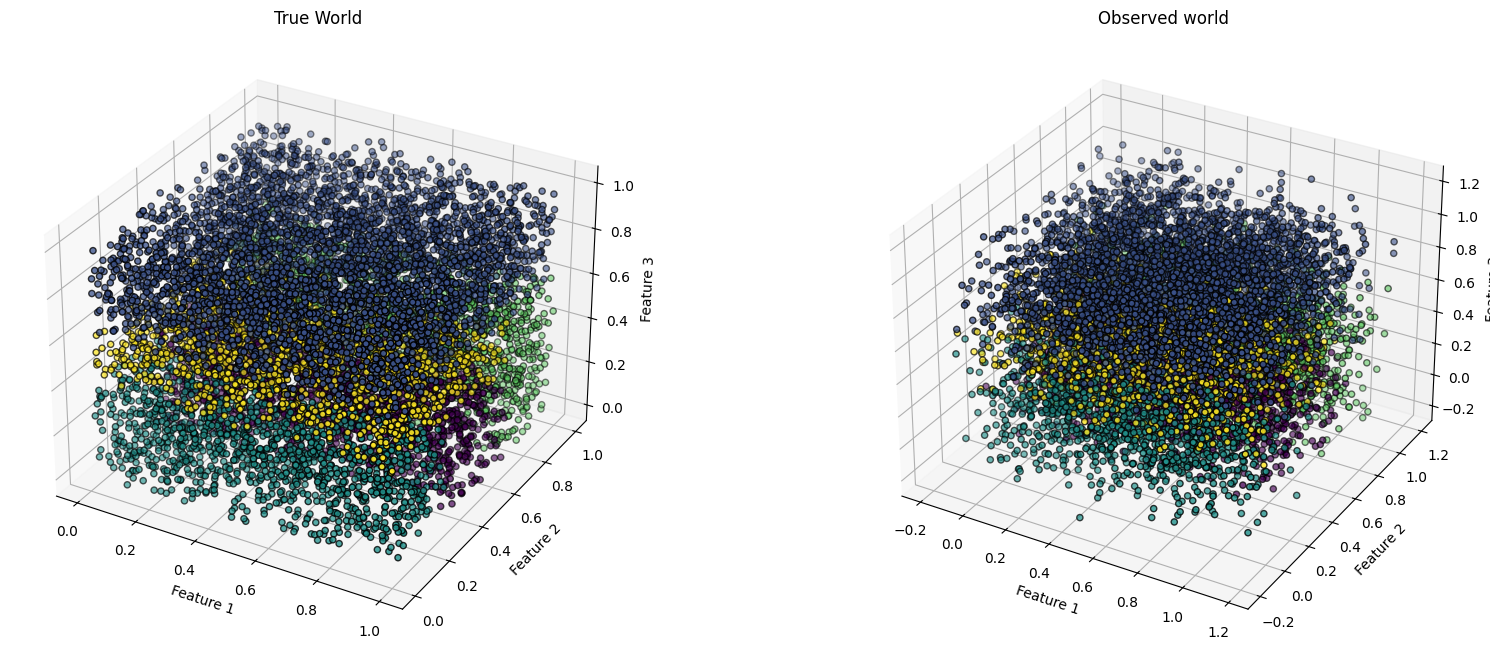

In [4]:
feature_bounds = (0, 1)
world_coords = generate_world_bounds(features = 3, feature_bounds = feature_bounds, endT = .2, endA = .20,  max_depth = 3)
bounds_with_class = {}

for i, bounds in enumerate(world_coords):
    bounds_with_class[bounds] = i

data = generate_true_values(bounds_with_class, feature_bounds)

world = data_to_world(data, errRange = 0.2, corr = 1)

plot_combined_3d(world)

## Testing 

In [9]:
from trees.util.uncertaintreelearner import UncertainTreeLearner
from trees.util.uncertainforestutil import UncertainForestLearner
from trees.owtree import ClassificationTreeLearner
from Orange.modelling import RandomForestLearner
from Orange.classification.logistic_regression import LogisticRegressionLearner
from Orange.modelling.constant import ConstantLearner

post_hoc = UncertainTreeLearner(max_depth=None, min_samples_leaf=2, min_samples_split=4, sufficient_majority=0.90, post_hoc=True)
skl_tree = ClassificationTreeLearner(max_depth=None, min_samples_leaf=2, min_samples_split=4, sufficient_majority=0.90)
uncertain_forest = UncertainForestLearner(n_trees=10, max_depth=None, min_samples_split=4)
random_forest = RandomForestLearner(n_trees=10, max_depth=None, min_samples_split=4, max_features = None)
logistic_regression = LogisticRegressionLearner(penalty=None)
majority = ConstantLearner()
# ridge = LogisticRegressionLearner(penalty="l2")

In [10]:
from Orange.evaluation import TestOnTestData
from Orange.evaluation.scoring import CA

def get_world_results(seed, features, errRange, NUMBER_OF_CLASSES, n_sample, rep): 
    results = []
    for err_range in errRange:
        print(f"  World Seed {seed}, errRange {err_range}")
        np.random.seed(seed)
        world = generate_world(seed, features, 
                            feature_bounds = feature_bounds, 
                            endT = .2, endA = .3, max_depth = 4,
                            class_number = NUMBER_OF_CLASSES,
                            errRange = err_range, corr = 1)
        data, test_data = convert_np_to_orange(world, features)
        for samples_per_class in n_sample:
            average_CA = np.array([0, 0, 0], dtype="float64")
            majority_class = CA(TestOnTestData(test_data, test_data=test_data, learners=[majority]))[0]
            for _ in range(rep):
                res = TestOnTestData(data=sample_data_orange(data, samples_per_class), test_data=test_data, learners=[skl_tree, post_hoc, uncertain_forest])
                average_CA += CA(res)
                # print(sample_data_orange(data, samples_per_class))
                # print(f"    samples_per_class: {samples_per_class}\n    Results:")
            average_CA = average_CA / rep * 100
            results.append([features, seed, err_range, samples_per_class, average_CA[0], average_CA[1], average_CA[2], majority_class])
            # print(f"  Results {samples_per_class}:\n      skl_tree          {round(average_CA[0], 2)}%\n      post_hoc          {round(average_CA[1], 2)}%\n      uncertain_forest  {round(average_CA[2], 2)}%")
    return results
            

In [11]:
from ploting import draw_world_from_seed

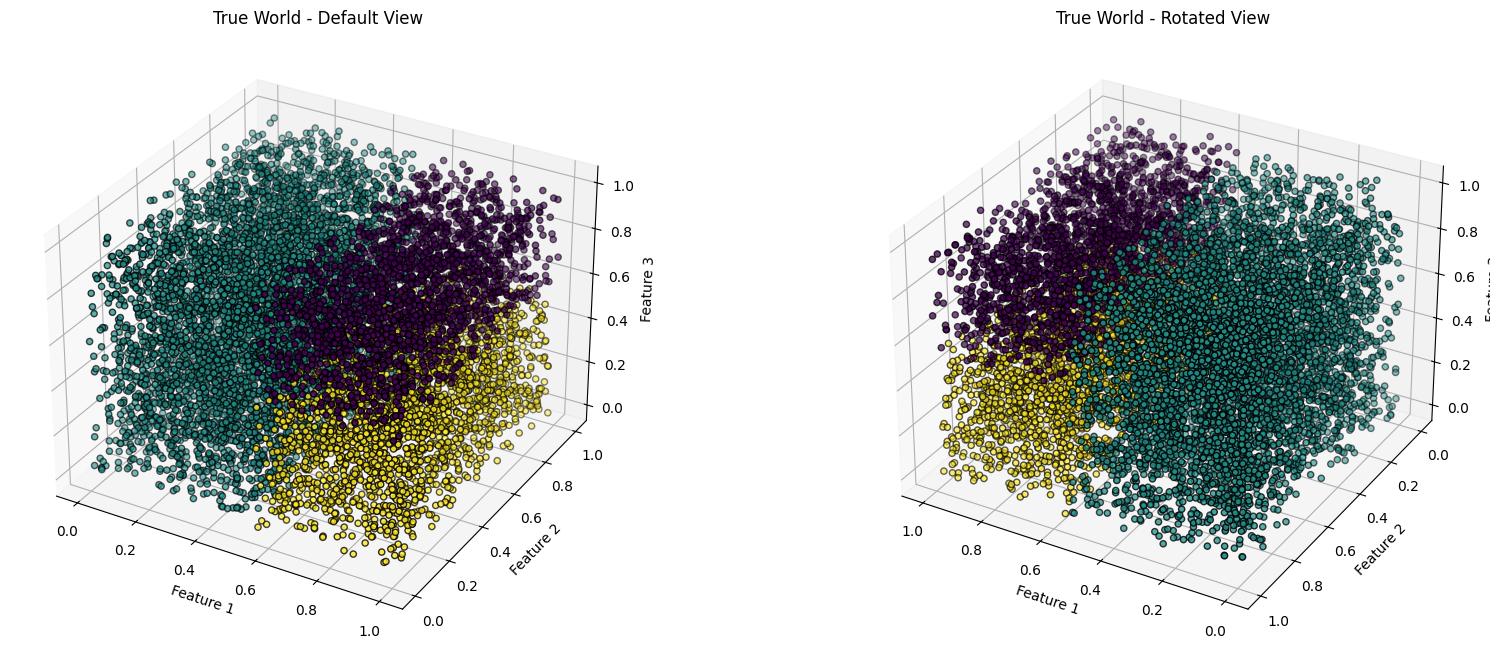

In [12]:
draw_world_from_seed(3, 3, 3)

In [13]:
# np.array(get_world_results(3, 3, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 3, [40], 33))

In [14]:
import Orange
Orange.version.full_version

'3.37.0'

In [15]:
from IPython.core.display import HTML

# Custom CSS to change the background color of the progress bar
display(HTML("""
    <style>
        .progress .progress-bar {
            background-color: #f60 !important; /* Change the progress bar background color to black */
        }
    </style>
"""))


### 2 Class

In [21]:
import numpy as np
from concurrent.futures import as_completed, ProcessPoolExecutor
from Orange.evaluation import TestOnTestData
from Orange.evaluation.scoring import CA
from tqdm.notebook import tqdm


feature_bounds = (0, 1)
n_feat = [3]
n_worlds = 50
n_sample = [5, 10, 20, 40]
rep = 33
errRange = list(np.arange(0, 11) / 10)
NUMBER_OF_CLASSES = 2
endT=.2
endArea = [.3]
max_depth = 4
learners = [skl_tree, post_hoc, uncertain_forest, random_forest, logistic_regression]
correlation = [0.9, 0.8, 0.7, 0.6]

# Function to be executed in parallel
def run_experiment(features, world_gen_seed, err_range, n_sample, learners, endA = .2, correlation = 1):
    np.random.seed(world_gen_seed)
    world = generate_world(world_gen_seed, features, 
                           feature_bounds=feature_bounds, 
                           endT=endT, endA=endA, max_depth=max_depth,
                           class_number=NUMBER_OF_CLASSES,
                           errRange=err_range, corr=correlation)
    data, test_data = convert_np_to_orange(world, features)
    results = []
    majority_class = CA(TestOnTestData(test_data, test_data=test_data, learners=[majority]))[0]
    for samples_per_class in n_sample:
        for _ in range(rep):
            res = TestOnTestData(data=sample_data_orange(data, samples_per_class), 
                                test_data=test_data, 
                                learners=learners)
            results.append([features, world_gen_seed, err_range, samples_per_class] + [val for val in CA(res)] + [majority_class])                    
    return results

# Main execution block
results = []

feat_PB = tqdm(total=n_worlds*len(errRange))
for corr in correlation:
    for endA in endArea:
        for features in n_feat:
            feat_PB.set_description(desc=f"{features} Feat correlation {corr}")
            feat_PB.reset()
            with ProcessPoolExecutor() as executor:
                futures = []
                for world_gen_seed in range(n_worlds):
                    for err_range in errRange:
                        futures.append(executor.submit(run_experiment, features, world_gen_seed, err_range, n_sample, learners, endA, corr))
                
                for future in as_completed(futures):
                    results += future.result()
                    feat_PB.update()

            df = pd.DataFrame(results, columns=["Features", "World", "errRange", "n_samples", "skl", "post_hoc", "uncertain_forest", "random_forest", "logistic_regression", "majority"])
            df.to_csv(f"results{features}feat_{n_worlds}worlds_{endA}endA_{NUMBER_OF_CLASSES}-clases_{corr}-correlation.csv", index=False)
            results = []

# Process results as needed


  0%|          | 0/550 [00:00<?, ?it/s]

### 3 Class

In [15]:
import numpy as np
from concurrent.futures import as_completed, ProcessPoolExecutor
from Orange.evaluation import TestOnTestData
from Orange.evaluation.scoring import CA
from tqdm.notebook import tqdm


feature_bounds = (0, 1)
n_feat = [2, 3]
n_worlds = 50
n_sample = [5, 10, 20, 40]
rep = 33
errRange = list(np.arange(0, 11) / 10)
NUMBER_OF_CLASSES = 3
endT=.2
endArea = [.3, .2, .1]
max_depth = 4
learners = [skl_tree, post_hoc, uncertain_forest, random_forest, logistic_regression]

# Function to be executed in parallel
def run_experiment(features, world_gen_seed, err_range, n_sample, learners, endA = .2):
    np.random.seed(world_gen_seed)
    world = generate_world(world_gen_seed, features, 
                           feature_bounds=feature_bounds, 
                           endT=endT, endA=endA, max_depth=max_depth,
                           class_number=NUMBER_OF_CLASSES,
                           errRange=err_range, corr=1)
    data, test_data = convert_np_to_orange(world, features)
    results = []
    majority_class = CA(TestOnTestData(test_data, test_data=test_data, learners=[majority]))[0]
    for samples_per_class in n_sample:
        for _ in range(rep):
            res = TestOnTestData(data=sample_data_orange(data, samples_per_class), 
                                test_data=test_data, 
                                learners=learners)
            results.append([features, world_gen_seed, err_range, samples_per_class] + [val for val in CA(res)] + [majority_class])                    
    return results

# Main execution block
results = []

feat_PB = tqdm(total=n_worlds*len(errRange))
for endA in endArea:
    for features in n_feat:
        feat_PB.set_description(desc=f"{features} Feat endArea {endA}")
        feat_PB.reset()
        with ProcessPoolExecutor() as executor:
            futures = []
            for world_gen_seed in range(n_worlds):
                for err_range in errRange:
                    futures.append(executor.submit(run_experiment, features, world_gen_seed, err_range, n_sample, learners, endA))
            
            for future in as_completed(futures):
                results += future.result()
                feat_PB.update()

        df = pd.DataFrame(results, columns=["Features", "World", "errRange", "n_samples", "skl", "post_hoc", "uncertain_forest", "random_forest", "logistic_regression", "majority"])
        df.to_csv(f"results{features}feat_{n_worlds}worlds_{endA}endA_{NUMBER_OF_CLASSES}-clases.csv", index=False)
        results = []

# Process results as needed


  0%|          | 0/550 [00:00<?, ?it/s]

### ostalo

In [25]:
import numpy as np
from Orange.evaluation import TestOnTestData
from Orange.evaluation.scoring import CA
from tqdm.notebook import tqdm
import multiprocessing as mp
import pandas as pd

feature_bounds = (0, 1)
n_feat = [2]
n_worlds = 2
n_sample = [5, 10, 20, 40]
rep = 33
errRange = list(np.arange(0, 11) / 10)
NUMBER_OF_CLASSES = 2
endT = .2
endArea = [.1, .2, .3]
max_depth = 4
learners = [skl_tree, post_hoc, uncertain_forest, random_forest, lasso, ridge]

# Function to be executed in parallel
def run_experiment(args):
    features, world_gen_seed, err_range, n_sample, learners, endA = args
    np.random.seed(world_gen_seed)
    world = generate_world(world_gen_seed, features, 
                           feature_bounds=feature_bounds, 
                           endT=endT, endA=endA, max_depth=max_depth,
                           class_number=NUMBER_OF_CLASSES,
                           errRange=err_range, corr=1)
    data, test_data = convert_np_to_orange(world, features)
    results = []
    for samples_per_class in n_sample:
        for _ in range(rep):
            res = TestOnTestData(data=sample_data_orange(data, samples_per_class), 
                                test_data=test_data, 
                                learners=learners)
            results.append([features, world_gen_seed, err_range, samples_per_class] + [val for val in CA(res)])                    
    return results


results = []

feat_PB = tqdm(total=n_worlds*len(errRange))
    
for endA in endArea:
    for features in n_feat:
        feat_PB.set_description(desc=f"{features} Feat endArea {endA}")
        feat_PB.reset()

        # Prepare a list of arguments for parallel processing
        tasks = [
            (features, world_gen_seed, err_range, n_sample, learners, endA)
            for world_gen_seed in range(n_worlds)
            for err_range in errRange
        ]

        # Use multiprocessing Pool to execute tasks in parallel
        with mp.Pool(mp.cpu_count()) as pool:
            for result in pool.imap_unordered(run_experiment, tasks):
                results.extend(result)
                feat_PB.update()

        # Save results after each feature/endA combination
        # df = pd.DataFrame(results, columns=["Features", "World", "errRange", "n_samples", "skl", "post_hoc", "uncertain_forest", "random_forest", "lasso", "ridge"])
        # df.to_csv(f"results{features}feat_{n_worlds}worlds_{endA}endA.csv", index=False)
        # results = []


  0%|          | 0/22 [00:00<?, ?it/s]